C:\Users\Hasan\PycharmProjects\untitled2\venv\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\Hasan\PycharmProjects\untitled2\venv\lib\site-packages\ipykernel_launcher.py:155: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\Hasan\PycharmProjects\untitled2\venv\lib\site-packages\ipykernel_launcher.py:165: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\Hasan\PycharmProjects\untitled2\venv\lib\site-packages\ipykernel_launcher.py:169: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
C:\Users\Hasan\PycharmProjects\untitled2\venv\lib\site

(256, 256)
(255, 255)
(255, 255)
The PSNR of GT and Output iss 20.746992995861845, the PSNR of GT and Blurred Image is 20.497630173285614


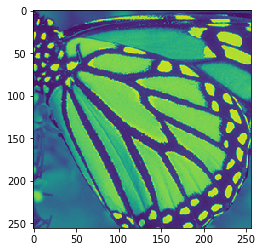

In [5]:
import time
import os
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import scipy
import scipy.misc
import pdb
import skimage
from skimage import measure



def imread(path, is_grayscale=True):
    
    
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
    
  if is_grayscale:
    return scipy.misc.imread(path, flatten=True, mode='YCbCr').astype(np.float)
  else:
    return scipy.misc.imread(path, mode='YCbCr').astype(np.float)

img = imread("butterfly_GT.bmp")
#1st task
print(img.shape)

plt.imshow(img)

def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image

def preprocess(path, scale=3):
  """
  Preprocess single image file 
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  image = image / 255.
  label_ = label_ / 255.

  input_ = scipy.ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
  input_ = scipy.ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

  return input_, label_

"""Set the image hyper parameters
"""
c_dim = 1
input_size = 255

"""Define the model weights and biases 
"""

# define the placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, [None, input_size, input_size, c_dim], name='inputs')

# replace '0' with your hyper parameter numbers 

#Add weights and bias terms 
# variabiles (w1, w2, w3)
weights = {
    'w1': tf.Variable(tf.random_normal([9, 9, 1, 64], stddev=1e-3), name='w1'),
    'w2': tf.Variable(tf.random_normal([1, 1, 64, 32], stddev=1e-3), name='w2'),
    'w3': tf.Variable(tf.random_normal([5, 5, 32, 1], stddev=1e-3), name='w3')
    }

biases = {
      'b1': tf.Variable(tf.zeros([64]), name='b1'),
      'b2': tf.Variable(tf.zeros([32]), name='b2'),
      'b3': tf.Variable(tf.zeros([1]), name='b3')
    }

# conv1 layer with biases: 64 filters with size 9 x 9
conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(inputs, weights['w1'], strides=[1,1,1,1], padding='SAME'), biases['b1']))


# conv2 layer with biases and relu: 32 filters with size 1 x 1
conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv1, weights['w2'], strides=[1,1,1,1], padding='SAME'), biases['b2']))

# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
conv3 = tf.nn.bias_add(tf.nn.conv2d(conv2, weights['w3'], strides=[1,1,1,1], padding='SAME'), biases['b3'])


"""Load the pre-trained model file
"""
model_path='C:/Users/Hasan/Desktop/CW1/CW1/CW1_Handout_Template_code/tf-SRCNN/model/model.npy'
model = np.load(model_path, encoding='latin1').item()



"""Initialize the model variabiles (w1, w2, w3, b1, b2, b3) with the pre-trained model file
"""
# launch a session
sess = tf.Session()

for key in weights.keys():
  sess.run(weights[key].assign(model[key]))

for key in biases.keys():
  sess.run(biases[key].assign(model[key]))

"""Read the test image
"""
blurred_image, groudtruth_image = preprocess('butterfly_GT.bmp')

"""Run the model and get the SR image
"""
# transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(blurred_image, axis =0), axis=-1)

# run the session
# here you can also run to get feature map like 'conv1' and 'conv2'
output_ = sess.run(conv3, feed_dict={inputs: input_})

input_ = np.squeeze(input_, axis=0)
input_ = np.squeeze(input_, axis=2)
#print(input_.shape)
scipy.misc.imsave("bicubic_int.bmp", input_)
# hints: use the 'scipy.misc.imsave()'  and ' skimage.meause.compare_psnr()'

output_ = np.squeeze(output_, axis=0)
output_ = np.squeeze(output_, axis=2)
#import pdb
#pdb.set_trace()


scipy.misc.imsave("final_output_1.bmp", output_)

groudtruth_image =  modcrop(groudtruth_image, 3)

scipy.misc.imsave("ground_truth.bmp", groudtruth_image)


print(groudtruth_image.shape)
print(output_.shape)
#print(output_.shape)


psnr_1 = skimage.measure.compare_psnr(groudtruth_image, output_)
psnr_2 = skimage.measure.compare_psnr(groudtruth_image, blurred_image)

print("The PSNR of GT and Output iss {}, the PSNR of GT and Blurred Image is {}".format(psnr_1, psnr_2))